# Fem un seguidor de línia utilitzant la càmera del robot

En aquesta ocasió, farem un seguidor de línia utilitzant la càmera del robot. Per a això, farem servir la càmera per capturar imatges del terra i processar-les per detectar la línia. A continuació, farem servir la informació obtinguda per controlar el robot i fer-lo seguir la línia.

Per a fer-ho, farem servir la llibreria `opencv` per processar les imatges i aitk.robots per controlar el robot.

Comencem per instal·lar i importar les llibreries necessàries:

In [1]:
!pip install aitk.robots numpy opencv-python-headless

In [2]:
import aitk.robots as bots
import numpy as np
import matplotlib.pyplot as plt
import cv2

Crearem el mon del robot i el robot. Necessitarem l'imatge [`pista_4.png`](https://lawer.github.io/mia/apunts/9.-Rob%C3%B3tica/pista_4.png) per aquest exemple, que conté una pista amb una línia negra.

El robot comptarà amb una càmera que capturarà imatges del terra i les processarà per detectar la línia. Serà de tipus `GroundCamera` i l'afegirem al robot.

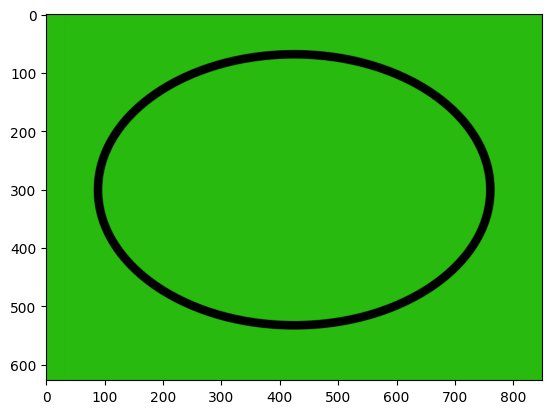

In [8]:
# Baixem pista_4.png utilitzant requests

import requests

url = "https://lawer.github.io/mia/apunts/9.-Rob%C3%B3tica/pista_4.png"

response = requests.get(url)

# Guardem la imatge en pista_4.png

with open("pista_4.png", "wb") as f:
    f.write(response.content)

# Carreguem la imatge en una variable

img = cv2.imread("pista_4.png")

# Mostrem la imatge
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [5]:
world = bots.World(220, 180, boundary_wall_color="yellow", ground_image_filename="pista_4.png")

robot = bots.Scribbler(x=23, y=90, a=90)
robot.add_device(bots.GroundCamera(width=100, height=50))

world.add_robot(robot)

robot['ground-camera'].watch()
world.watch()

Random seed set to: 4724504


HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00d\x00\x00\x002\x08\x06\x00\x00\x00\xaa5~\xbe\x00\…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

Using random seed: 4724504


  0%|          | 0/1200 [00:00<?, ?it/s]

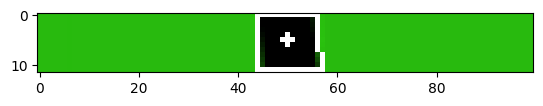

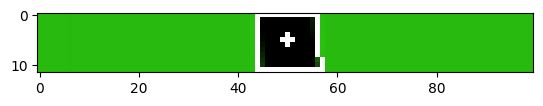

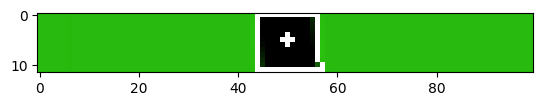

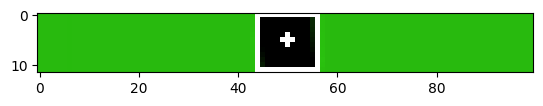

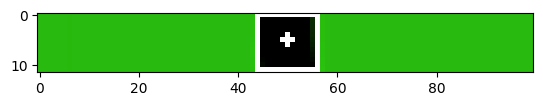

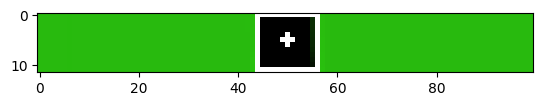

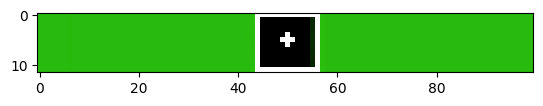

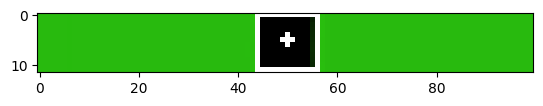

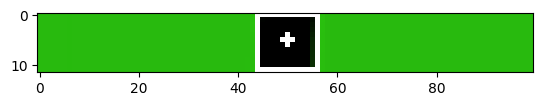

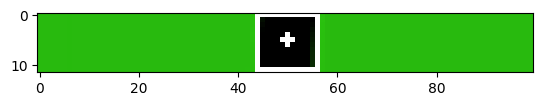

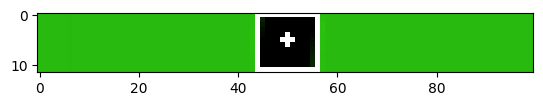

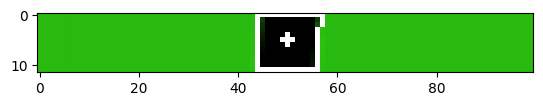

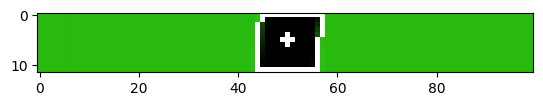

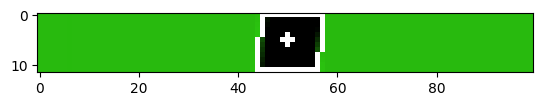

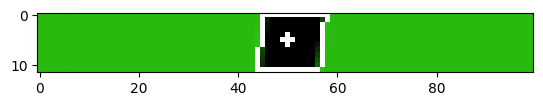

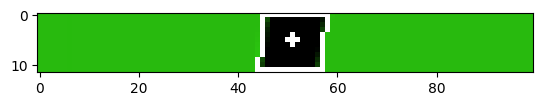

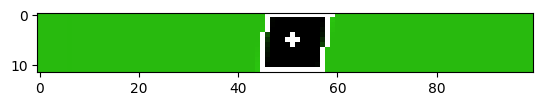

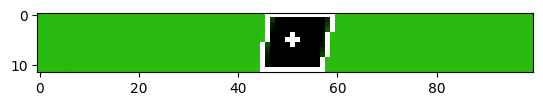

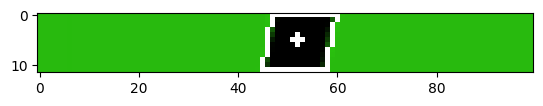

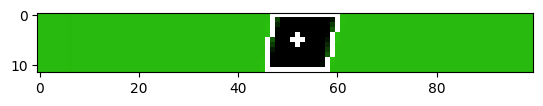

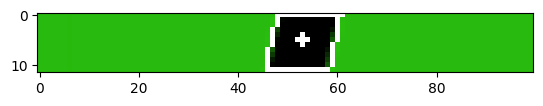

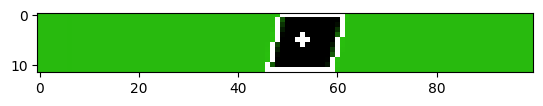

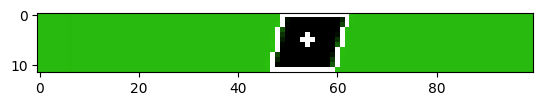

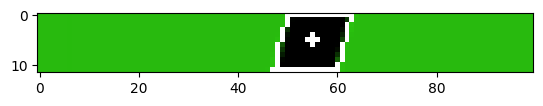

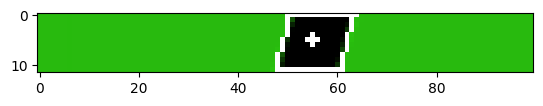

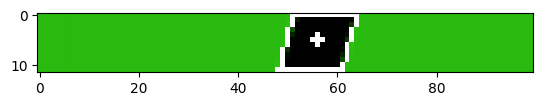

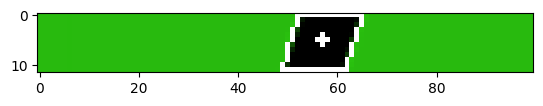

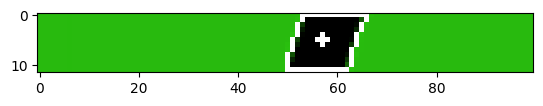

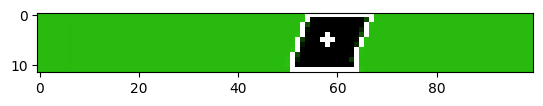

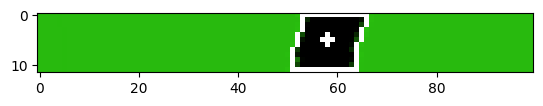

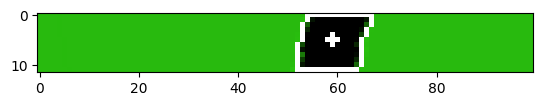

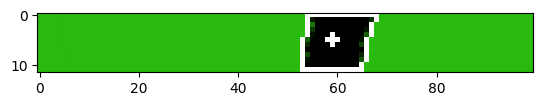

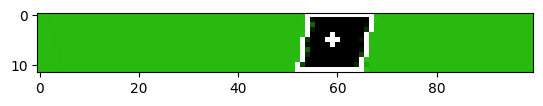

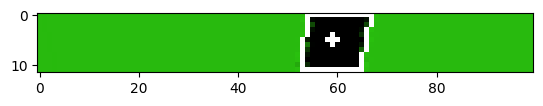

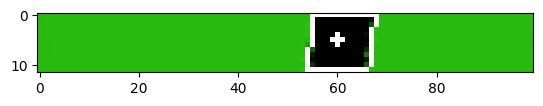

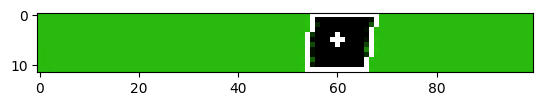

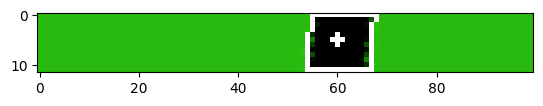

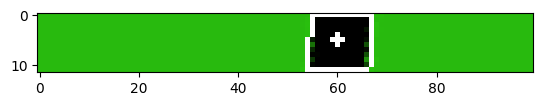

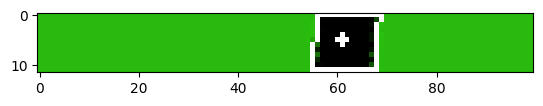

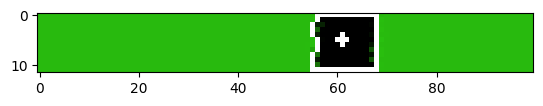

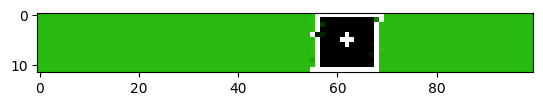

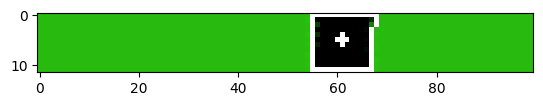

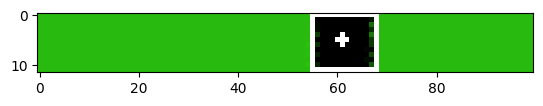

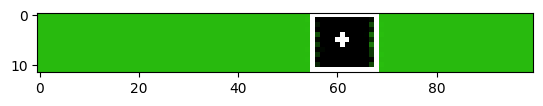

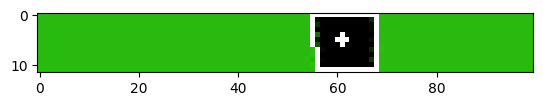

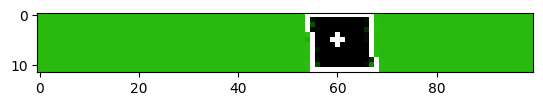

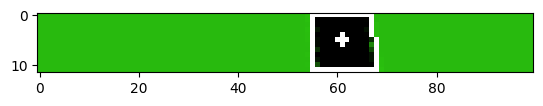

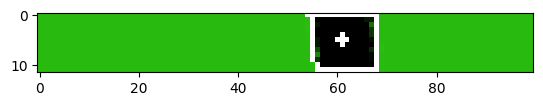

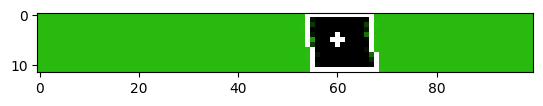

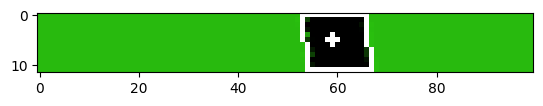

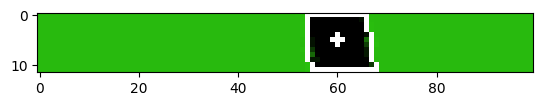

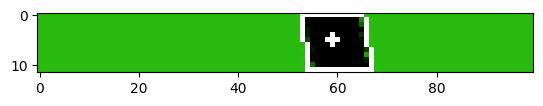

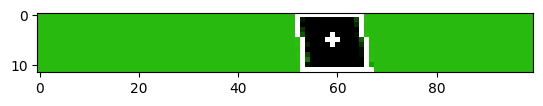

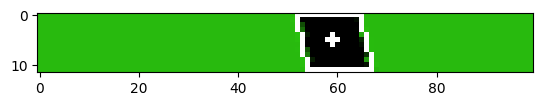

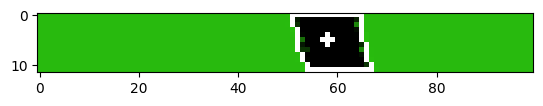

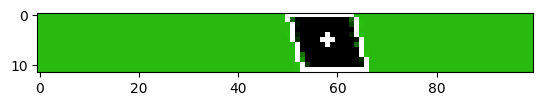

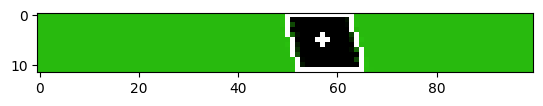

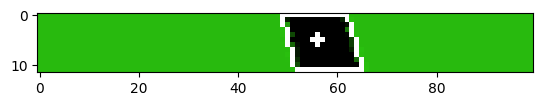

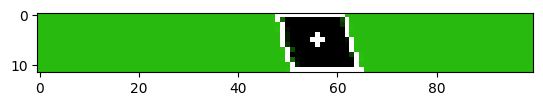

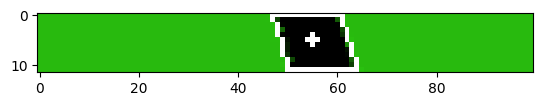

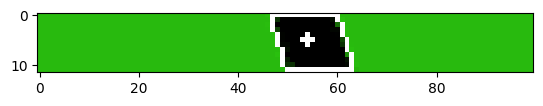

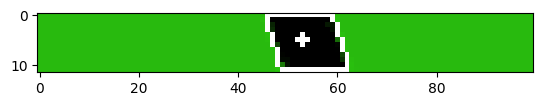

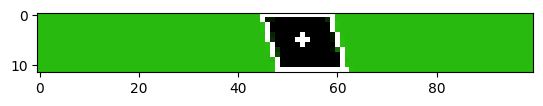

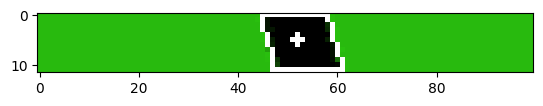

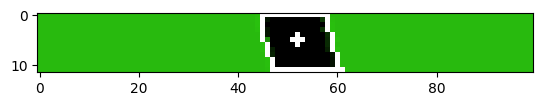

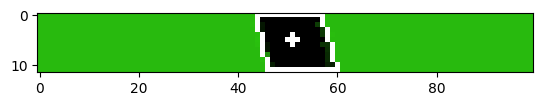

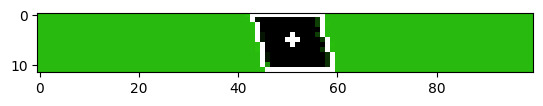

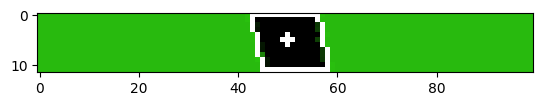

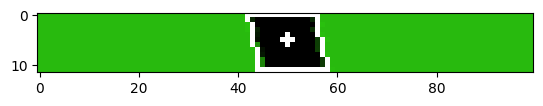

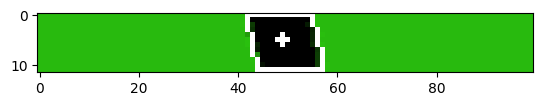

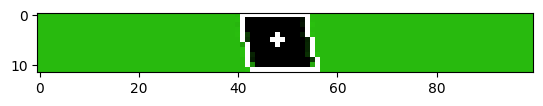

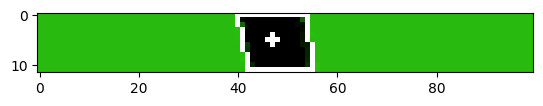

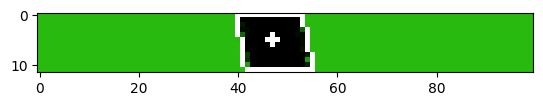

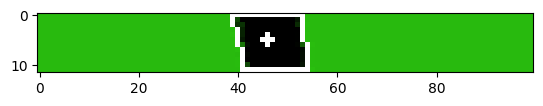

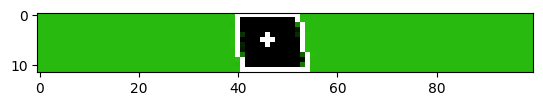

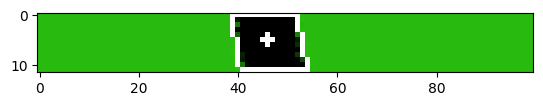

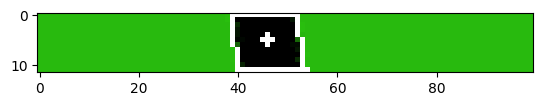

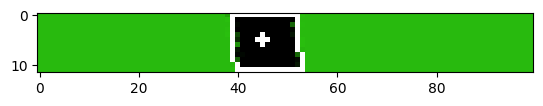

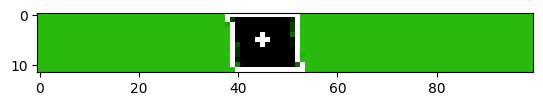

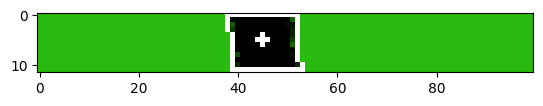

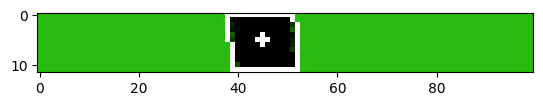

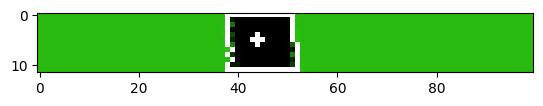

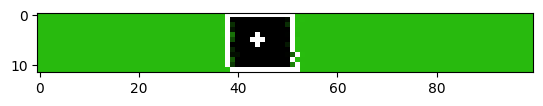

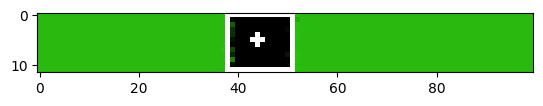

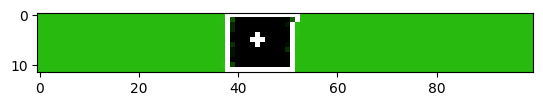

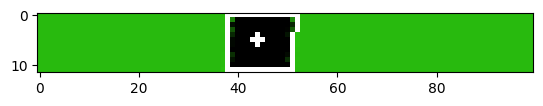

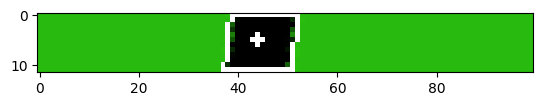

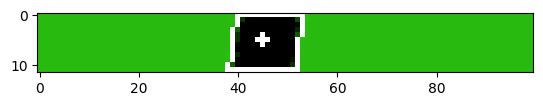

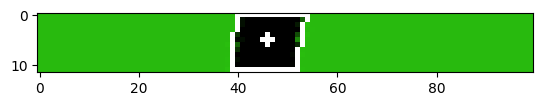

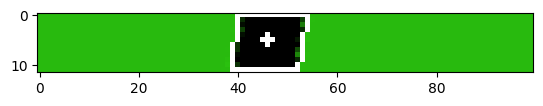

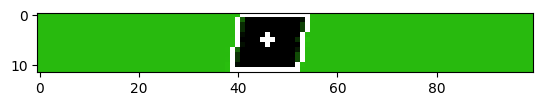

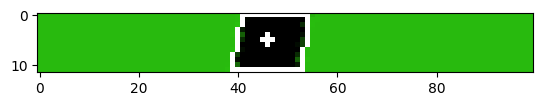

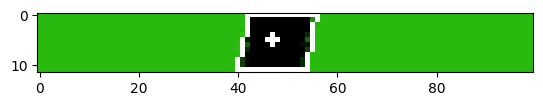

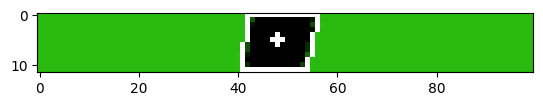

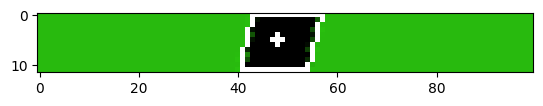

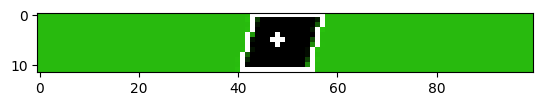

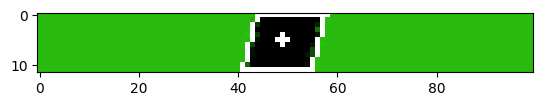

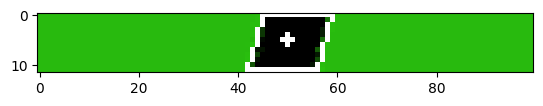

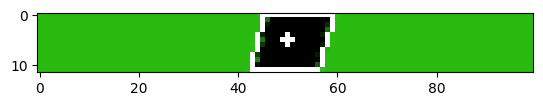

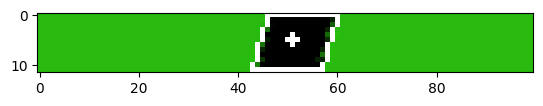

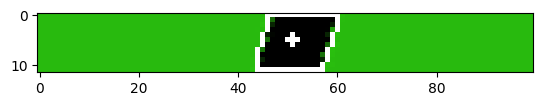

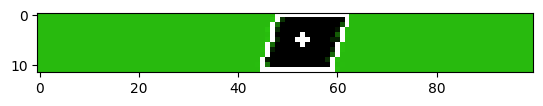

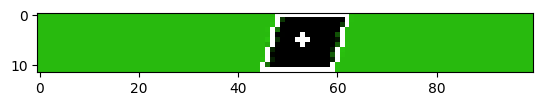

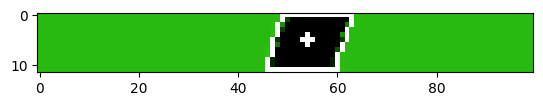

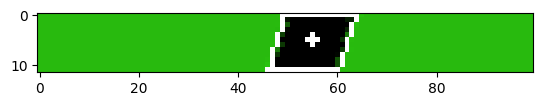

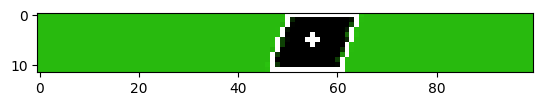

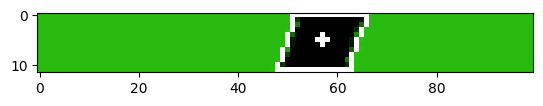

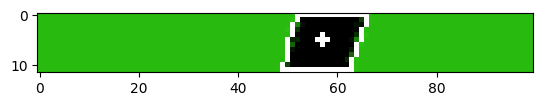

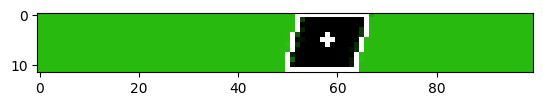

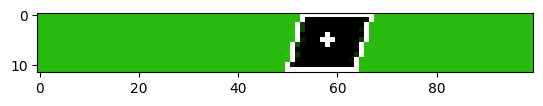

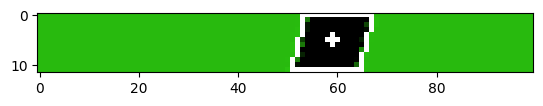

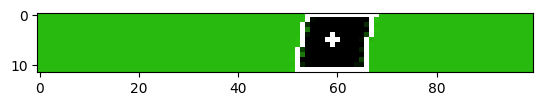

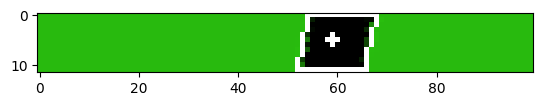

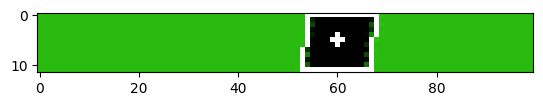

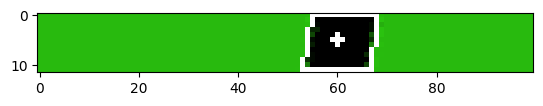

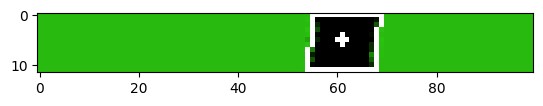

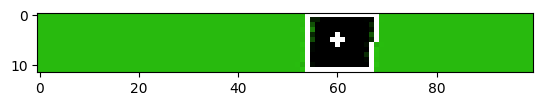

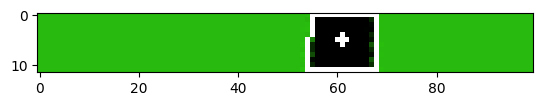

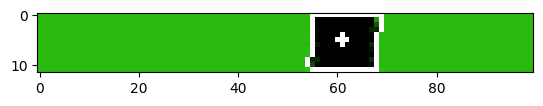

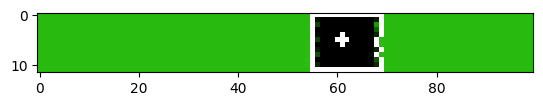

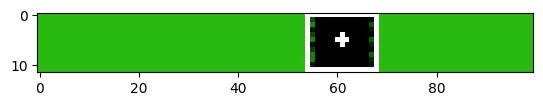

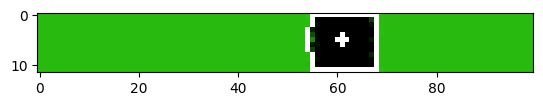

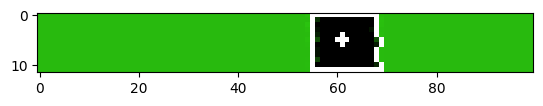

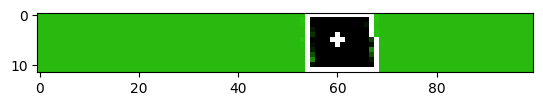

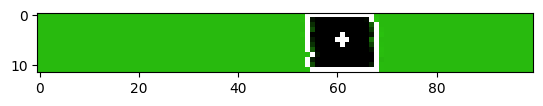

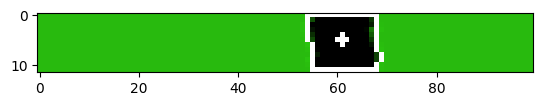

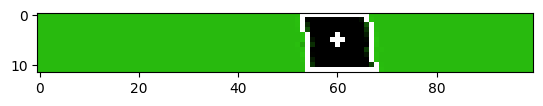

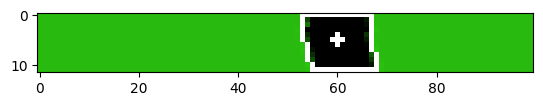

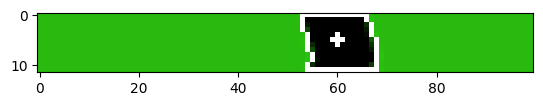

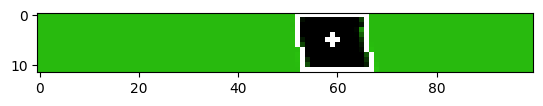

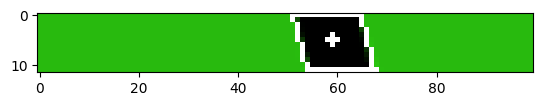

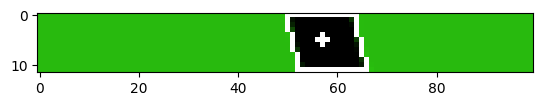

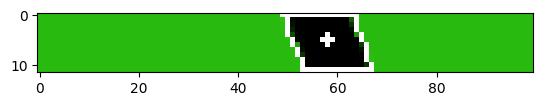

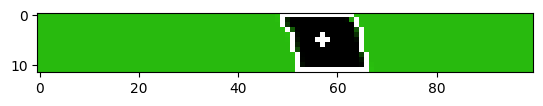

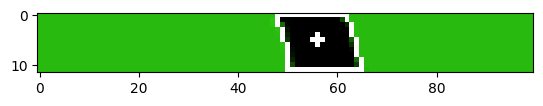

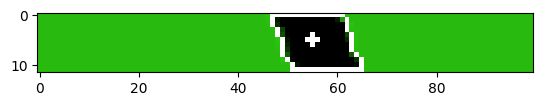

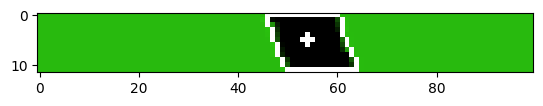

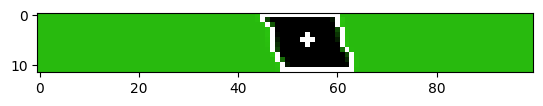

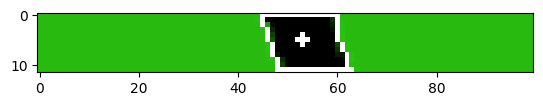

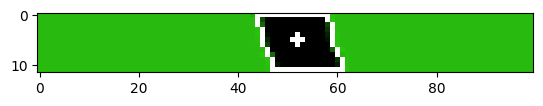

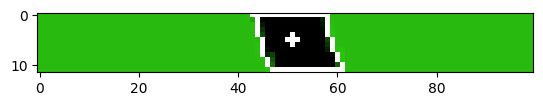

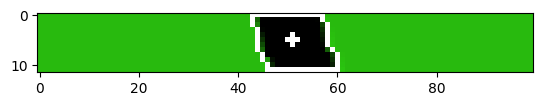

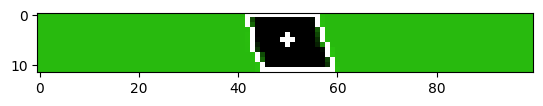

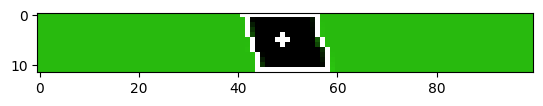

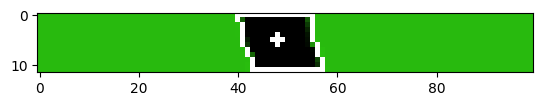

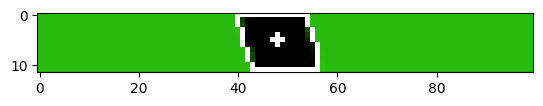

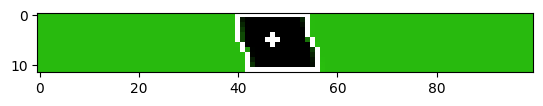

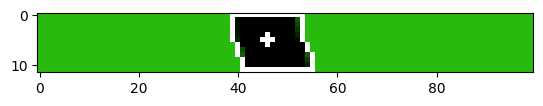

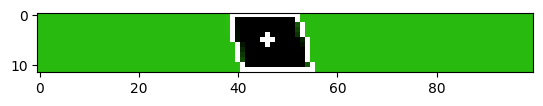

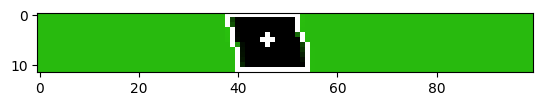

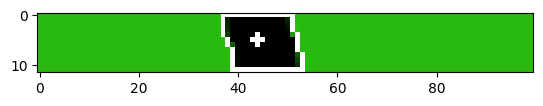

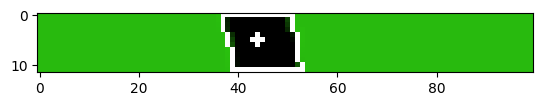

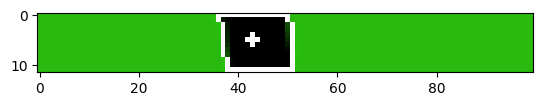

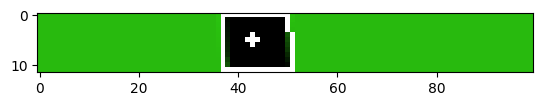

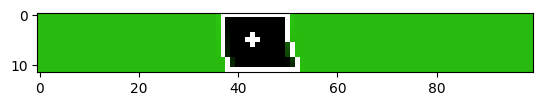

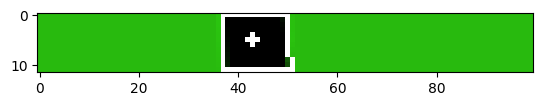

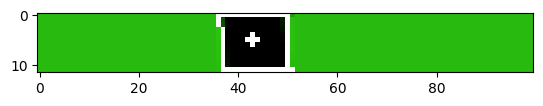

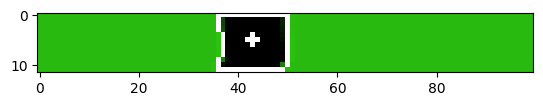

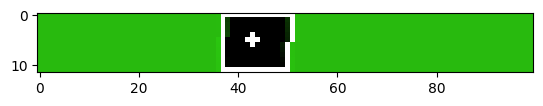

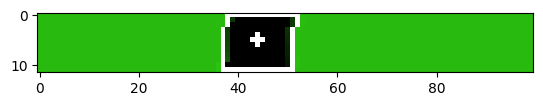

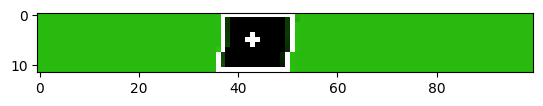

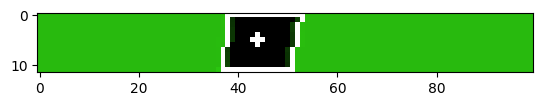

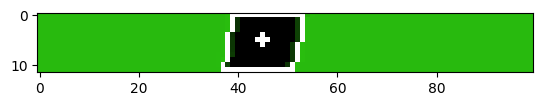

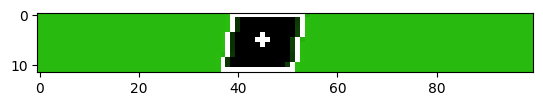

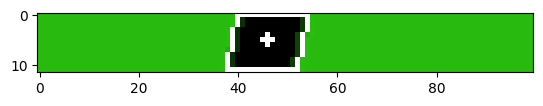

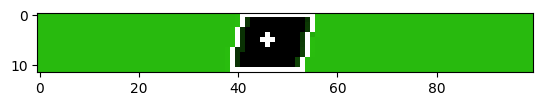

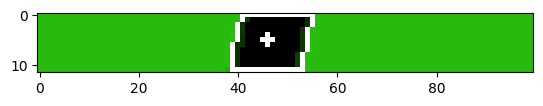

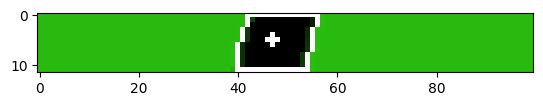

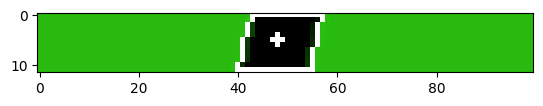

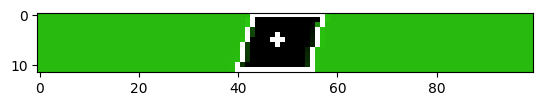

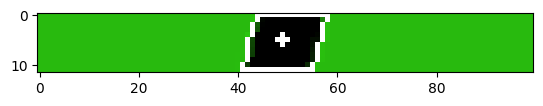

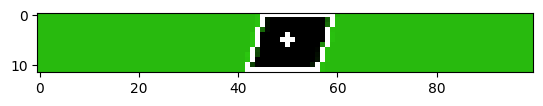

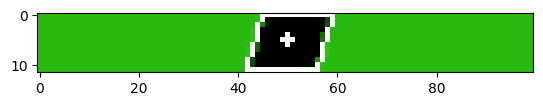

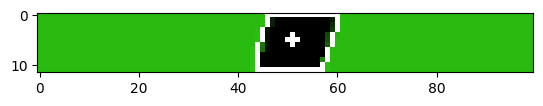

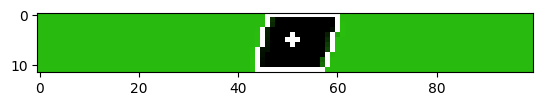

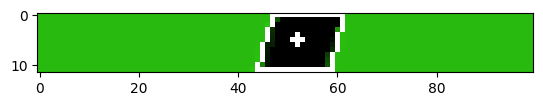

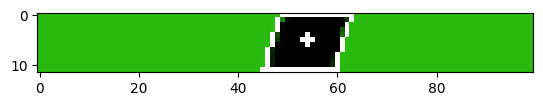

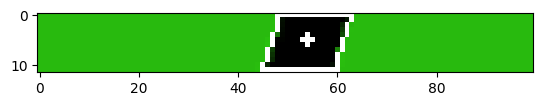

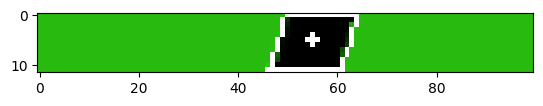

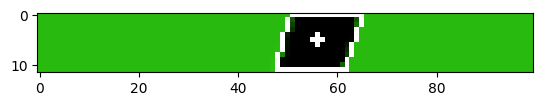

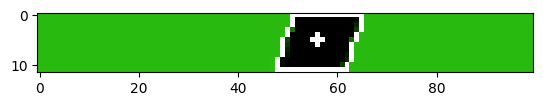

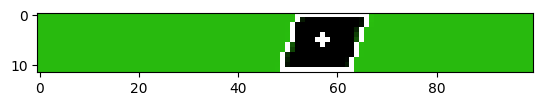

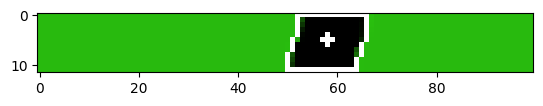

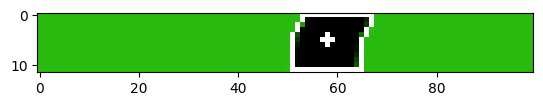

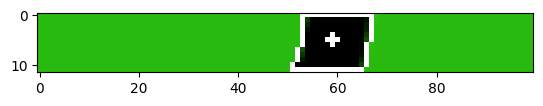

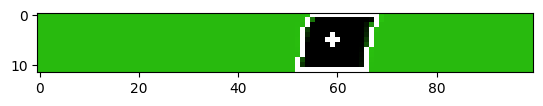

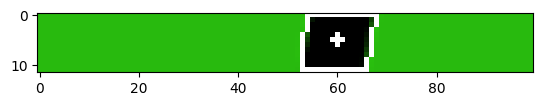

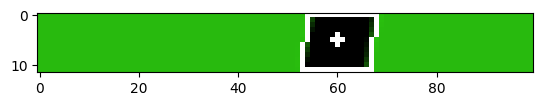

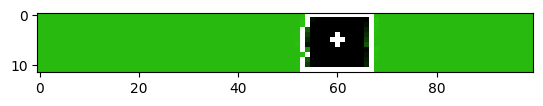

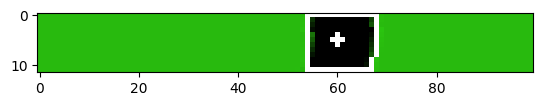

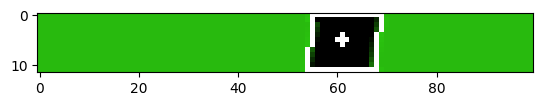

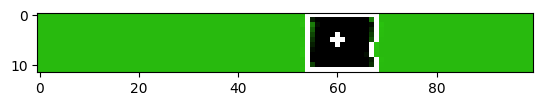

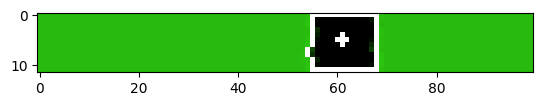

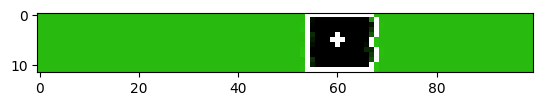

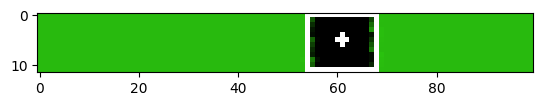

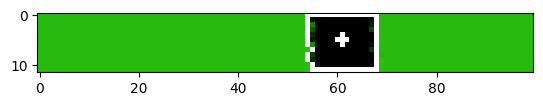

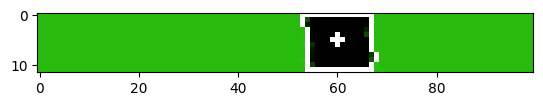

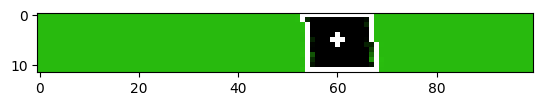

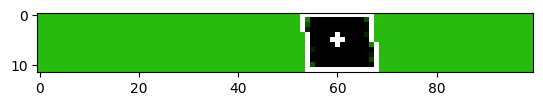

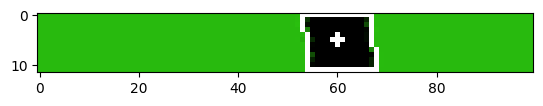

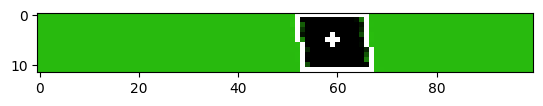

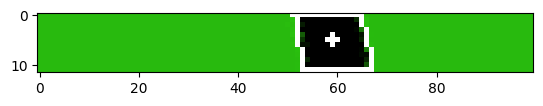

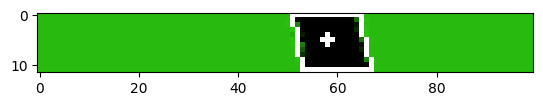

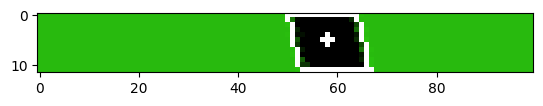

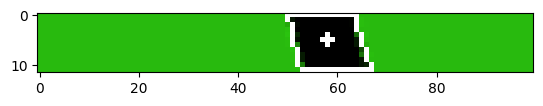

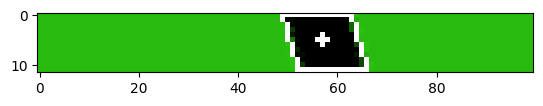

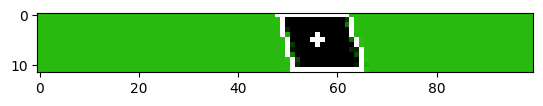

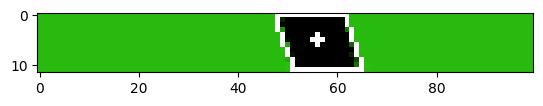

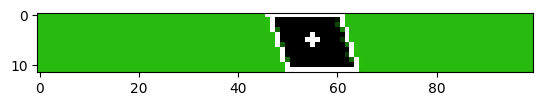

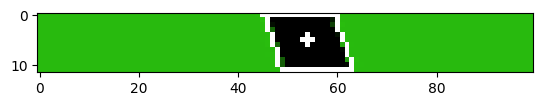

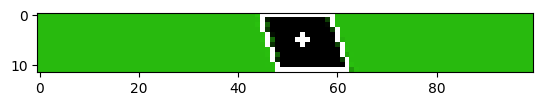

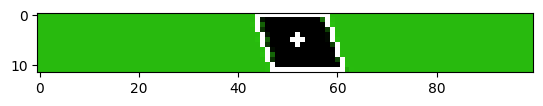

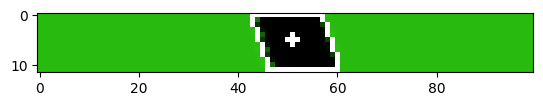

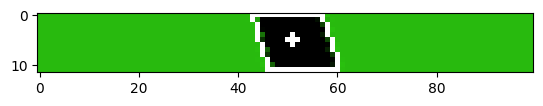

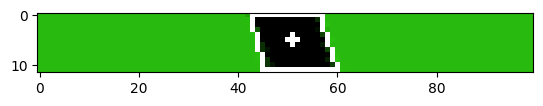

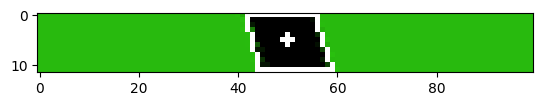

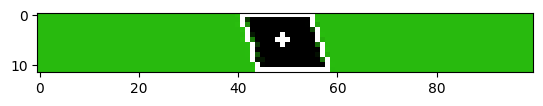

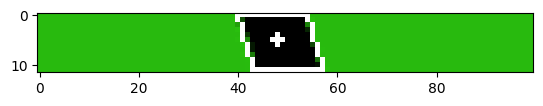

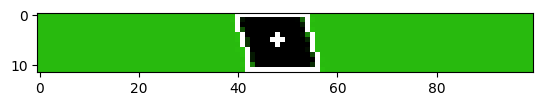

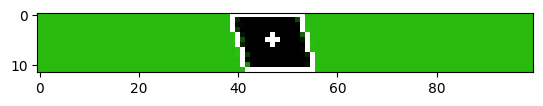

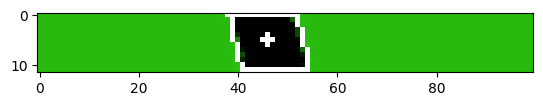

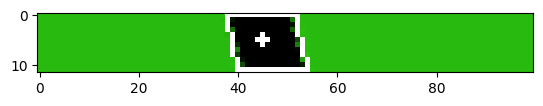

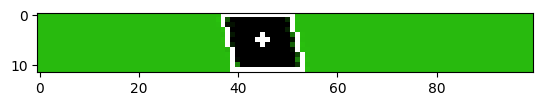

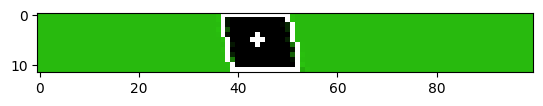

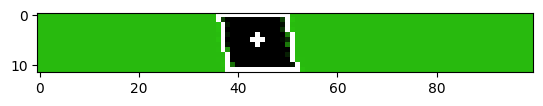

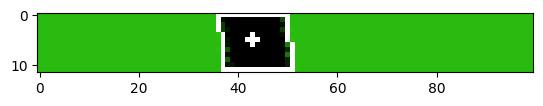

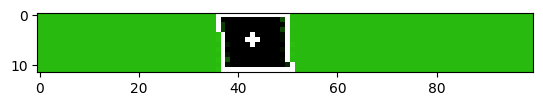

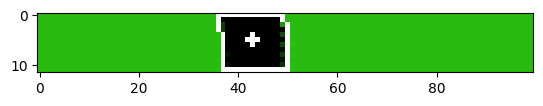

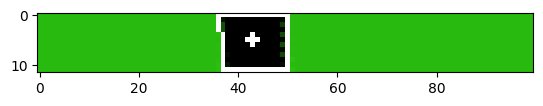

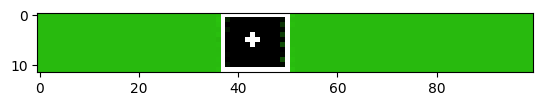

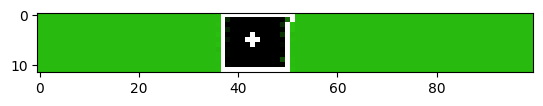

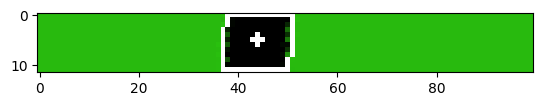

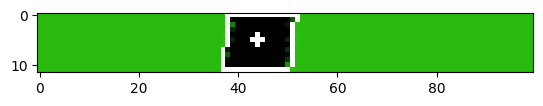

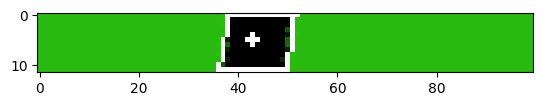

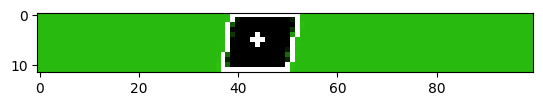

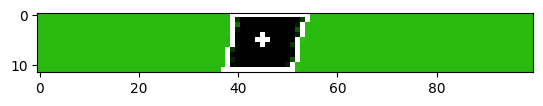

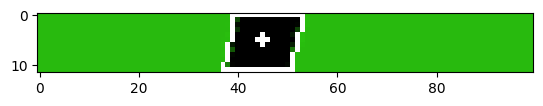

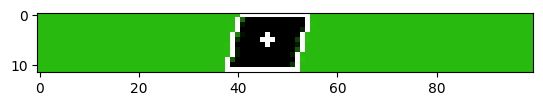

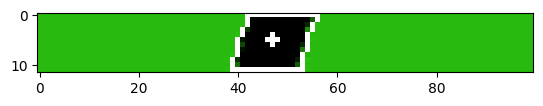

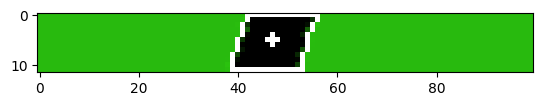

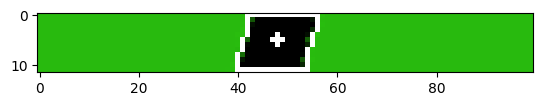

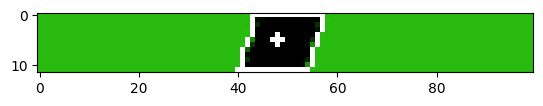

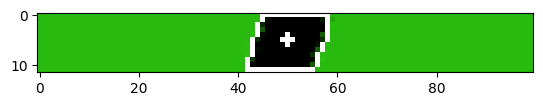

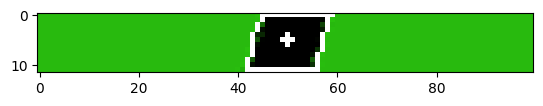

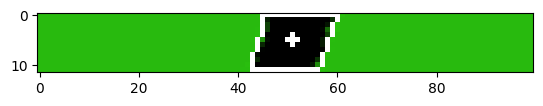

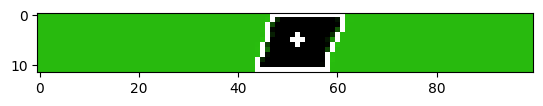

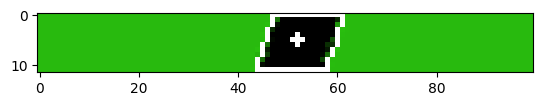

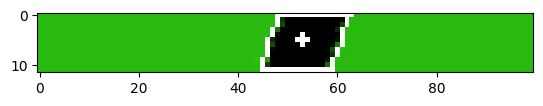

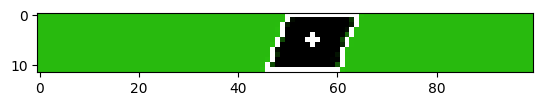

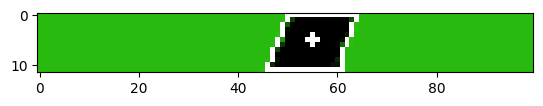

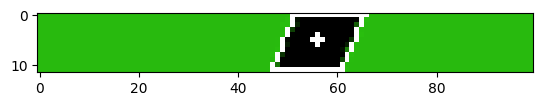

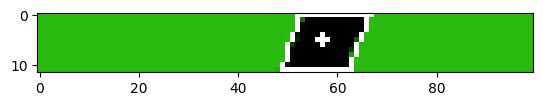

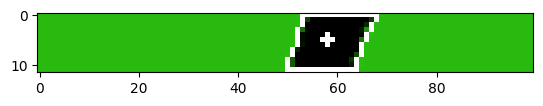

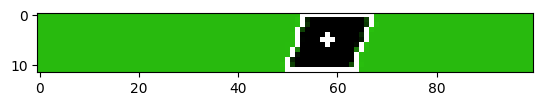

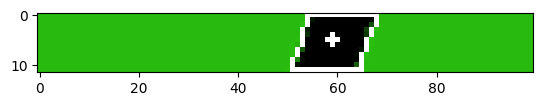

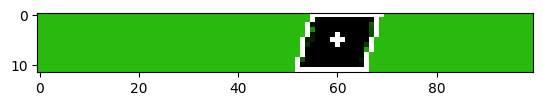

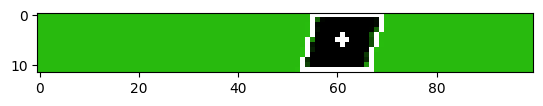

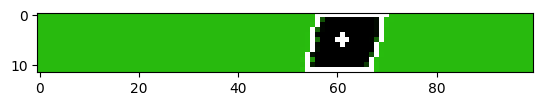

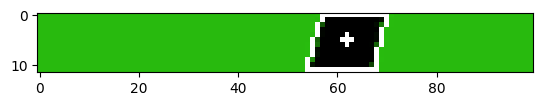

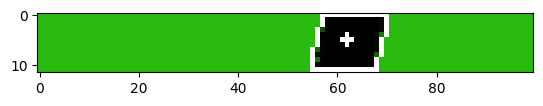

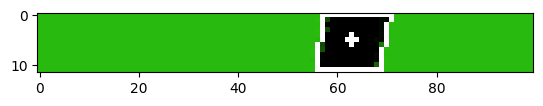

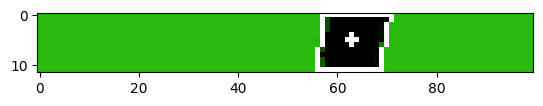

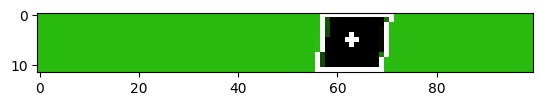

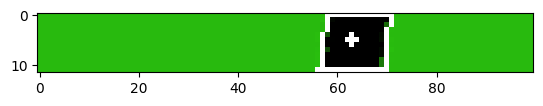

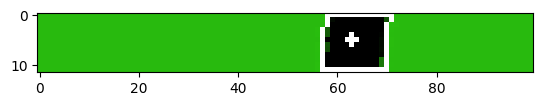

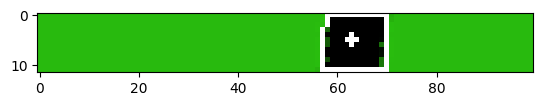

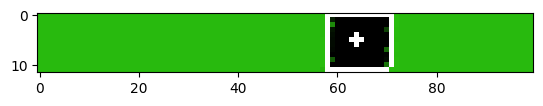

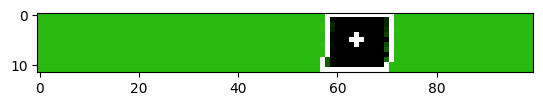

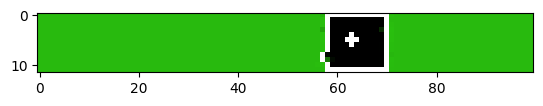

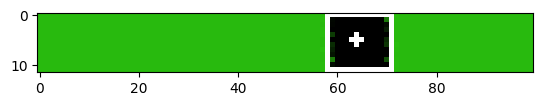

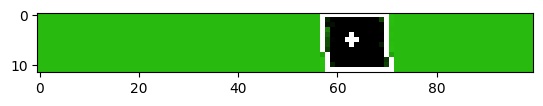

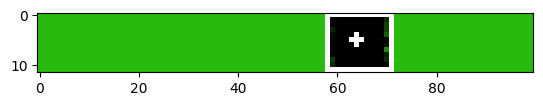

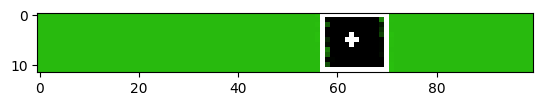

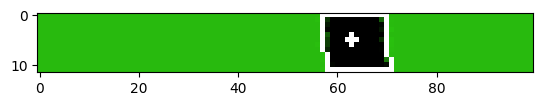

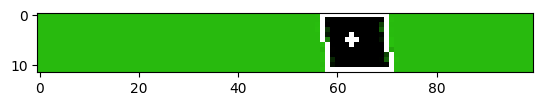

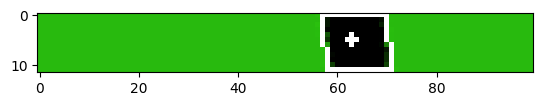

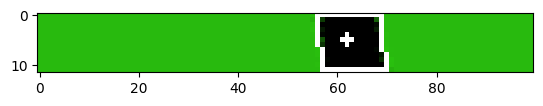

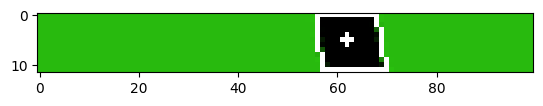

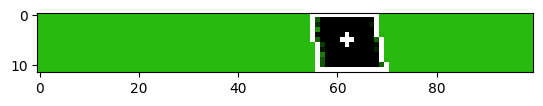

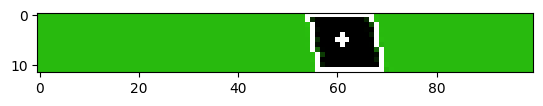

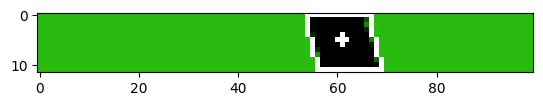

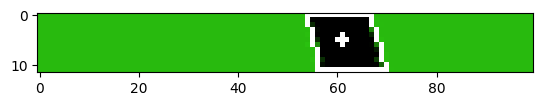

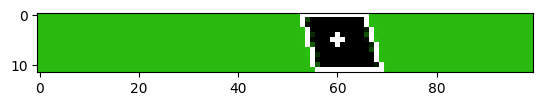

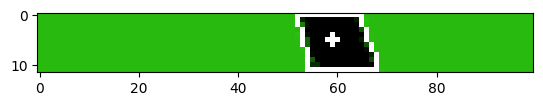

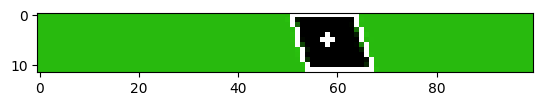

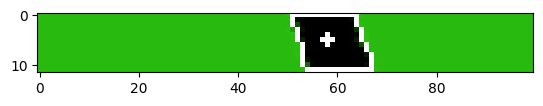

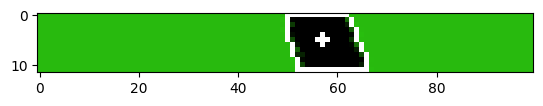

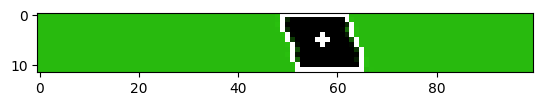

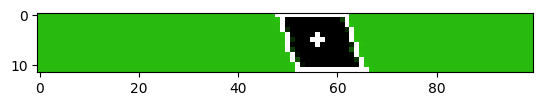

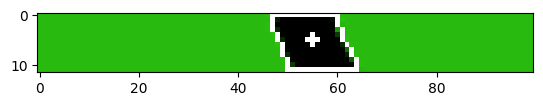

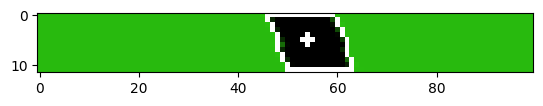

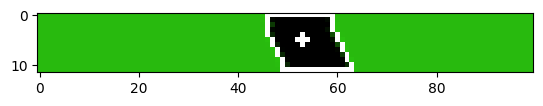

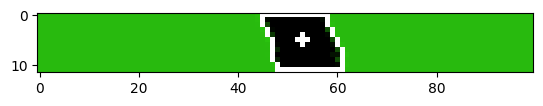

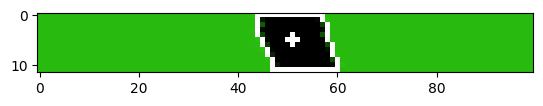

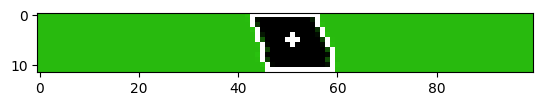

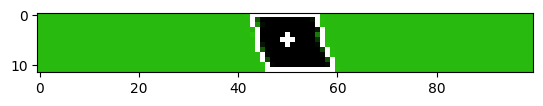

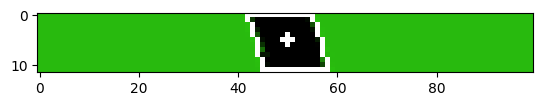

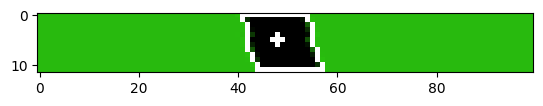

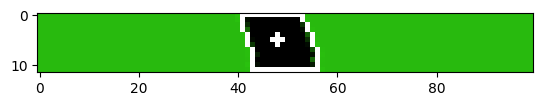

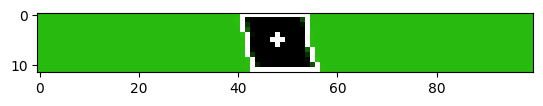

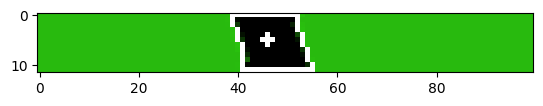

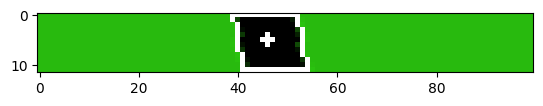

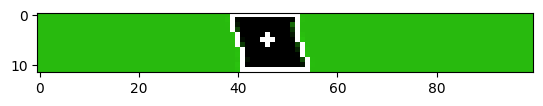

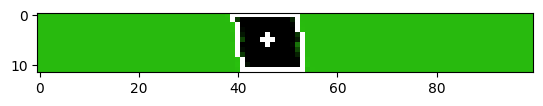

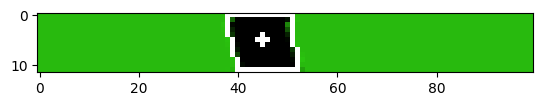

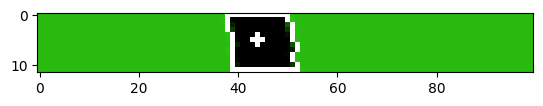

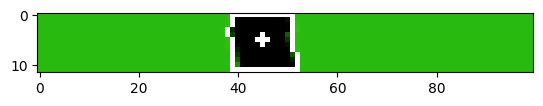

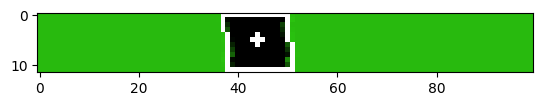

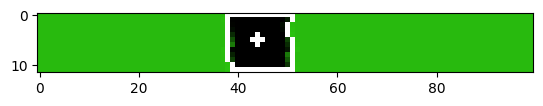

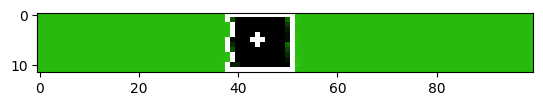

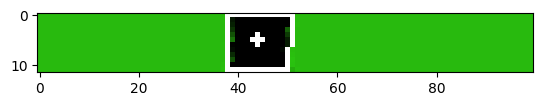

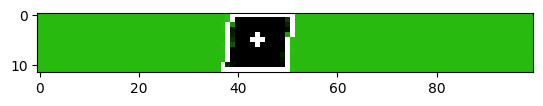

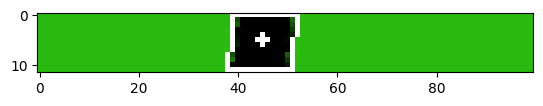

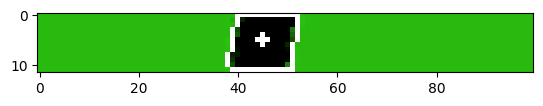

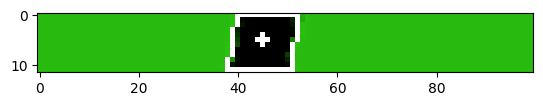

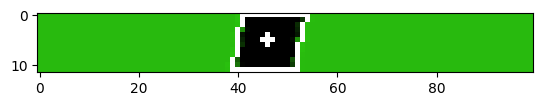

Simulation stopped at: 00:00:31.60; speed 1.37 x real time


In [6]:
def controlador_cam(robot):
    cam = robot['ground-camera']
    image = cam.get_image()

    # convertim la imatge a un array de numpy per treballar en OpenCV
    im = np.array(image)
 
    # ens quedem amb la part baixa de la imatge
    im_baix = im[20:32, 0:100]

    # convertim a escala de grisos
    im_bn = cv2.cvtColor(im_baix, cv2.COLOR_RGB2GRAY)

    # apliquem un filtre de desenfocament
    im_blurred = cv2.GaussianBlur(im_bn, (5, 5), 0)

    # binaritzem la imatge
    ret, im_thresh = cv2.threshold(im_blurred, 100, 200, cv2.THRESH_BINARY_INV)

    # busquem els contorns
    contours, hierarchy = cv2.findContours(im_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # dibuixem els contorns
    cv2.drawContours(im_baix, contours, -1, (0, 255, 0), 1)

    # calculem el centre de la vora més gran
    if len(contours) > 0:
        cnt = max(contours, key=cv2.contourArea)
        M = cv2.moments(cnt)
        # En M tenim els moments de la imatge
        M00 = M['m00'] # area
        M01 = M['m01'] # sum(y)
        M10 = M['m10'] # sum(x)

        # Si l'area és diferent de 0 calculem el centre de massa
        if M00 != 0:
            cx = int(M10/M00)
            cy = int(M01/M00)

            # Dibuixem el centre de massa
            cv2.circle(im_baix, (cx, cy), 1, (255, 0, 0), -1)

            # Mostrem la imatge
            plt.imshow(im_baix)
            plt.show()

            # Movem el robot
            # Si el centre de massa està a l'esquerra del centre de la imatge, girem a l'esquerra
            # Si el centre de massa està a la dreta del centre de la imatge, girem a la dreta
            # Si el centre de massa està al centre de la imatge, anem recte
            # Tenim en compte una marge per no fer moviments petits
            marge = 5
            if cx < 100/2 - marge:
                robot.move(0.4, 0.1)
            elif cx > 100/2 + marge:
                robot.move(0.4, -0.1)
            else:
                robot.move(0.4, 0)   

world.reset()
world.seconds(120, [controlador_cam], real_time=False)